# Milestone P3 - Training pipeline

### Imports

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os

from transformers import AutoTokenizer, AutoModel, AutoConfig
from datasets import load_from_disk
from sklearn.cluster import KMeans
from safetensors.torch import load_file
import torch.nn.functional as F


d:\MiniConda\envs\clinical-clustering\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
ds_full = load_from_disk("./clinical_ds_cleaned")
ds_full= ds_full["train"]
print(ds_full)


Dataset({
    features: ['nct_id', 'brief_title_clean', 'brief_summary_clean', 'detailed_description_clean', 'eligibility_criteria_clean', 'keywords_clean', 'mesh_terms_clean', 'condition_browse_module_clean', 'intervention_browse_module_clean', 'conditions', 'interventions', 'combined_text', 'text_len'],
    num_rows: 479038
})


In [57]:
DEV_SIZE = 5000
ds_dev = ds_full.shuffle(seed=42).select(range(min(DEV_SIZE, ds_full.num_rows)))
print(ds_dev.num_rows)

5000


In [ ]:
model = None
tokenizer = None
model_name = "emilyalsentzer/Bio_ClinicalBERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.isdir("./model_saved"):
    print("Model and Tokenizer on disk")
    tokenizer = AutoTokenizer.from_pretrained("./model_saved")
    model = AutoModel.from_pretrained("./model_saved").to(device)
else:
    print("Model and Tokenizer download")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModel.from_config(config)
    state_dict = load_file("./model_safetensors/bioclinicalbert.safetensors") # to get safetensors version run the modelConvert.py script in the Kornimate/medical-research-forecast and save it to model_safetensors folder
    model.load_state_dict(state_dict)
    model.save_pretrained("./model_saved")
    tokenizer.save_pretrained("./model_saved")
    model = model.to(device)

model.eval()

Model and Tokenizer on disk


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Constants

In [61]:
MAX_LEN = 256
TEXT_FIELD_FOR_EMBEDDING = "combined_text"

### Function definition for embedding generation

In [ ]:
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    masked = last_hidden_state * mask
    summed = masked.sum(1)
    counts = mask.sum(1).clamp(min=1e-9)
    return summed / counts

def embed_batch(batch):
    texts = batch[TEXT_FIELD_FOR_EMBEDDING]

    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    with torch.no_grad():
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        pooled = mean_pool(outputs.last_hidden_state, enc["attention_mask"])
        pooled = F.normalize(pooled, p=2, dim=1)
        embeddings = pooled.cpu().numpy()

    batch["embedding"] = [e.astype(np.float32) for e in embeddings]
    return batch

### Run embedding generation

In [ ]:
ds_dev_emb = ds_dev.map(
    embed_batch,
    batched=True,
    batch_size=64
)

print(ds_dev_emb)
print(ds_dev_emb[0]["embedding"][:10])  # sanity check

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]d:\MiniConda\envs\clinical-clustering\lib\site-packages\transformers\models\bert\modeling_bert.py:413: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Map: 100%|██████████| 20000/20000 [03:20<00:00, 99.68 examples/s] 

Dataset({
    features: ['nct_id', 'brief_title_clean', 'brief_summary_clean', 'detailed_description_clean', 'eligibility_criteria_clean', 'keywords_clean', 'mesh_terms_clean', 'condition_browse_module_clean', 'intervention_browse_module_clean', 'conditions', 'interventions', 'combined_text', 'text_len', 'embedding'],
    num_rows: 20000
})
[-0.0077045876532793045, -0.01569448597729206, -0.01875791884958744, -0.00557815283536911, 0.0018089473014697433, -0.007056598551571369, -0.005387266632169485, 0.00820367131382227, 0.008357913233339787, 0.028743797913193703]


### Save to disk for check point

In [ ]:
ds_dev_emb.save_to_disk("clinical_trials_with_embeddings_test")

Saving the dataset (1/1 shards): 100%|██████████| 20000/20000 [00:00<00:00, 68126.40 examples/s]


### Run this checkpoint if crashed before

In [ ]:
ds_dev_emb = load_from_disk("./clinical_trials_with_embeddings_test")
ds_dev_emb

Dataset({
    features: ['nct_id', 'brief_title_clean', 'brief_summary_clean', 'detailed_description_clean', 'eligibility_criteria_clean', 'keywords_clean', 'mesh_terms_clean', 'condition_browse_module_clean', 'intervention_browse_module_clean', 'conditions', 'interventions', 'combined_text', 'text_len', 'embedding'],
    num_rows: 20000
})

### Untouched

In [17]:
from collections import Counter
import re

STOPWORDS = set([
    "and","or","of","in","all","by","with","without","a","the","an","to","for","type","site",
    "before","after","non","at","vs","i","ii","iii","iv","1","2","3","4","5",
    "patient", "patients", "study", "studies", "disease", "diseases", 
    "treatment", "treatments", "group", "groups", "criteria", "subject", 
    "subjects", "trial", "trials", "clinical", "randomized", "placebo",
    "intervention", "efficacy", "safety", "evaluate", "method", "results" ## common words that ruin the statistics
])

def valid_token(tok):
    tok = tok.lower().strip(",.()")
    if tok in STOPWORDS:
        return False
    if len(tok) <= 2 and not tok.isalpha():
        return False
    if tok.isdigit():
        return False
    return True

def get_tokens_from_field(dataset, field):
    for x in dataset[field]:
        if not x:
            continue
        for tok in str(x).split():
            yield tok.strip().lower()

anchor_fields = [
    "mesh_terms_clean",
    "condition_browse_module_clean",
    "intervention_browse_module_clean",
]

cnt = Counter()
for field in anchor_fields:
    for tok in get_tokens_from_field(ds_dev_emb, field):
        tok = tok.lower().strip(",.()")
        if valid_token(tok):
            cnt[tok] += 1

### Untouched

In [26]:
top_tokens = [tok for tok, _ in cnt.most_common(2000)]
ANCHOR_GROUPS = {
    "oncology": [
        "cancer", "neoplasm", "tumor", "carcinoma", "lymphoma", "leukemia",
        "melanoma", "metastasis"
    ],

    "cardiology": [
        "heart", "cardiac", "coronary", "myocardial", "hypertension",
        "arrhythmia", "ischemia"
    ],

    "neurology": [
        "brain", "stroke", "epilepsy", "neurodegenerative", "multiple_sclerosis"
    ],

    "endocrine": [
        "diabetes", "insulin", "thyroid", "glucose", "obesity"
    ],

    "respiratory": [
        "lung", "asthma", "pulmonary", "bronchial", "copd"
    ],

    "infectious_disease": [
        "virus", "viral", "bacterial", "antibiotic", "hiv", "covid-19"
    ],

    "gastrointestinal": [
        "colon", "colitis", "bowel", "ulcerative", "gastric"
    ],

    "musculoskeletal": [
        "arthritis", "osteoporosis", "muscle", "bone"
    ],

    "psychiatric": [
        "depression", "anxiety", "bipolar", "schizophrenia"
    ],

    "hematologic": [
        "anemia", "platelet", "coagulation", "thrombosis"
    ],
}

### Encode function used in multiple places

In [ ]:
def encode_texts(texts):
    """Encodes a list of texts and returns the pooled embeddings."""
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    with torch.no_grad():
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        # Use mean_pool, which is assumed to calculate the average of all tokens
        pooled = mean_pool(outputs.last_hidden_state, enc["attention_mask"])
    return pooled.cpu().numpy()

### Anchor embeddings calculated here as they are used during clustering as centroids 

In [ ]:
anchor_labels = list(ANCHOR_GROUPS.keys())
all_anchor_embs = []

for label in anchor_labels:
    keywords = ANCHOR_GROUPS[label]
    keyword_embs = encode_texts(keywords)
    topic_anchor_emb = np.mean(keyword_embs, axis=0)
    all_anchor_embs.append(topic_anchor_emb)

anchor_embs = np.stack(all_anchor_embs, axis=0)
anchor_embs = anchor_embs / np.linalg.norm(anchor_embs, axis=1, keepdims=True) # important puts it into cosine space that KMeans will use (like Spherical Kmeans)

### New Clustering using Kmeans as sperical Kmeans
no umap -> no data loss
Kmeans in normalized vector space is like spherical Kmeans -> curse of dimensionality does not pose problem as it is same like angle based clustering
predefined number of clusters -> Anchor Topics # + Extra clusters

"Euclidean distance on L2-normalized vectors is equivalent to cosine distance." --> no need for umap dim reduction

also problems with umap: (but we keep it for plotting)
 - UMAP changes every run
 - UMAP is nonlinear → destroys global distances
 - UMAP compresses semantics

Semantic embeddings encode meaning in direction, not magnitude

BERT-like embeddings differentiate texts almost entirely by angle.

Cosine similarity in high dimension is stable and meaningful

Because transformer embeddings live on a manifold where direction encodes semantics, not distance magnitude.

Spherical K-Means avoids the actual “curse of dimensionality”

The curse affects density-based distances (DBSCAN/HDBSCAN), but not cosine-based partitioning.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# 1) Get document embeddings
X = np.vstack(ds_dev_emb["embedding"]).astype(np.float32)

# 2) Normalize to unit length (cosine → euclidean equivalence)
X_norm = X / np.linalg.norm(X, axis=1, keepdims=True) # K-Means over L2-normalized vectors = Spherical K-Means.

# 3) Normalize anchor embeddings too
# IF NOT CALLED anchor_embs = anchor_embs / np.linalg.norm(anchor_embs, axis=1, keepdims=True) before this, do it here
anchor_centroids = anchor_embs # already in cosine space
A = anchor_centroids.shape[0]

# 4) Decide how many extra topics you want
E = 20  # E between 80-120 when working with whole dataset
K = A + E 

# 5) Sample extra centroids from the data
rng = np.random.default_rng(42)
extra_idx = rng.choice(X_norm.shape[0], size=E, replace=False)
extra_centroids = X_norm[extra_idx]

# 6) Build full centroid matrix
init_centroids = np.vstack([anchor_centroids, extra_centroids])

# 7) Run K-Means with custom init
kmeans = KMeans(
    n_clusters=K,
    init=init_centroids,
    n_init=1,           # important: we already gave centroids
    max_iter=300,
    random_state=42
)

cluster_labels_kmeans = kmeans.fit_predict(X_norm)

ds_dev_emb = ds_dev_emb.add_column(
    "cluster_kmeans_anchored",
    cluster_labels_kmeans.tolist()
)

d:\MiniConda\envs\clinical-clustering\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### Get # of recognized clusters (unsupervised / semi-supervised clustering with KMeans)

In [32]:
unique_vals = set(ds_dev_emb["cluster_kmeans_anchored"])
print(unique_vals)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


### Save to checkpoint if crashes happen

In [33]:
ds_dev_emb.save_to_disk("clinical_trials_with_embeddings_with_clusters_base_test")

Saving the dataset (1/1 shards): 100%|██████████| 5000/5000 [00:00<00:00, 80864.03 examples/s]


### Load from checkpoint

In [35]:
ds_dev_emb = load_from_disk("clinical_trials_with_embeddings_with_clusters_base_test")
print(ds_dev_emb)

Dataset({
    features: ['nct_id', 'brief_title_clean', 'brief_summary_clean', 'detailed_description_clean', 'eligibility_criteria_clean', 'keywords_clean', 'mesh_terms_clean', 'condition_browse_module_clean', 'intervention_browse_module_clean', 'conditions', 'interventions', 'combined_text', 'text_len', 'embedding', 'cluster_hdbscan_baseline', 'cluster_kmeans_anchored'],
    num_rows: 5000
})


### Visualize clustering

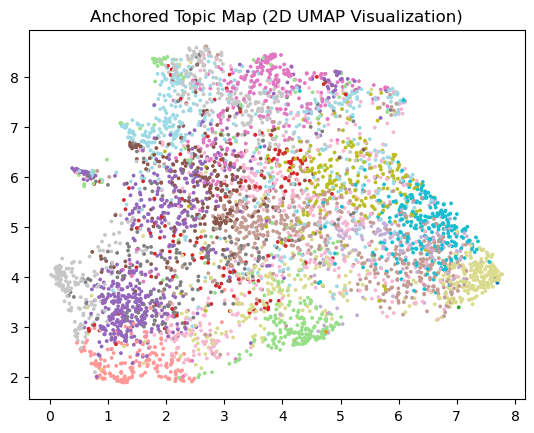

In [38]:
umap_vis = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="cosine")
X_2d = umap_vis.fit_transform(X_norm)

plt.scatter(X_2d[:,0], X_2d[:,1], c=cluster_labels_kmeans, s=3, cmap="tab20")
plt.title("Anchored Topic Map (2D UMAP Visualization)")
plt.show()


### Assign clusters to test split using frozen centroids 

In [ ]:
X_test = np.vstack(ds_test["embedding"])
X_test /= np.linalg.norm(X_test, axis=1, keepdims=True)

sim = cosine_similarity(X_test, centers)
test_cluster_labels = sim.argmax(axis=1)

### Compute soft anchor similarity weights for each document
gives a probability distribution over anchors for each document

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(X, anchor_embs)   # X = original doc embeddings
sims_std = (sims - sims.mean(axis=0)) / sims.std(axis=0)

tau = 1.0
weights = np.exp(sims_std / tau)
weights = weights / weights.sum(axis=1, keepdims=True)


### Post-anchoring function
 - Assigns each cluster a dominant anchor
 - Can return “other” if no strong anchor matches
 - Always preserves clustering geometry

“Given the clusters discovered from the data, which medical anchor (e.g., oncology, cardiology, neurology) best describes each cluster?” 
--> this is topic_anchored 

In [ ]:
def post_anchor_clusters(
    X,
    cluster_labels,
    anchor_embs,
    anchor_labels,
    anchor_threshold=0.55,
    other_label="other"
):
    sim_matrix = cosine_similarity(X, anchor_embs)
    
    unique_clusters = sorted(c for c in np.unique(cluster_labels))
    
    cluster_anchor_scores = {} # store sim score per cluster
    final_cluster_labels = {} # final labels to clusters

    for c in unique_clusters:
        # Mask selecting samples belonging to the current cluster
        mask = (cluster_labels == c)

        # Compute mean similarity to each anchor for this cluster
        mean_scores = sim_matrix[mask].mean(axis=0)
        cluster_anchor_scores[c] = mean_scores

        # Find the anchor with the highest mean similarity
        best_idx = np.argmax(mean_scores)
        best_score = mean_scores[best_idx]

        # Assign anchor label if similarity exceeds threshold,
        # otherwise assign the fallback "other" label
        if best_score >= anchor_threshold:
            final_cluster_labels[c] = anchor_labels[best_idx]
        else:
            final_cluster_labels[c] = other_label

    # Assign a topic label to each sample based on its cluster label
    assigned_topics = []
    for lbl in cluster_labels:
        assigned_topics.append(final_cluster_labels[lbl])

    # Return:
    # 1. Topic assigned to each sample
    # 2. Label assigned to each cluster
    # 3. Mean anchor similarity scores per cluster
    return assigned_topics, final_cluster_labels, cluster_anchor_scores


### Apply post-anchoring to your clustering results

In [ ]:
topics_anchored, anchor_map, anchor_scores = post_anchor_clusters(
    X=X,                                    # original 768-D embeddings
    cluster_labels=cluster_labels_kmeans,   # from ANY clustering algorithm
    anchor_embs=anchor_embs,                # computed above
    anchor_labels=anchor_labels,            # anchor names
    anchor_threshold=0.55                   # tuneable
)

### Add to dataset

In [42]:
ds_dev_emb = ds_dev_emb.add_column("topic_anchored", topics_anchored)


### Save checkpoint

In [43]:
ds_dev_emb.save_to_disk("clinical_trials_with_embeddings_with_clusters_base_with_topic_anchored_test")

Saving the dataset (1/1 shards): 100%|██████████| 5000/5000 [00:00<00:00, 39378.26 examples/s]


### Load checkpoint

In [ ]:
ds_dev_emb = load_from_disk("clinical_trials_with_embeddings_with_clusters_base_with_topic_anchored_test")
print(ds_dev_emb)

### Geometry metrics: These measure cluster quality independent of anchors

Interpretation:

Silhouette ↑ better

CH ↑ better

DB ↓ better

KMeans usually gives:

Higher CH

Lower DB

Moderate Silhouette

In [48]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("===== GEOMETRY METRICS (KMEANS) =====")

sil = silhouette_score(X_norm, cluster_labels_kmeans)
ch  = calinski_harabasz_score(X_norm, cluster_labels_kmeans)
db  = davies_bouldin_score(X_norm, cluster_labels_kmeans)

print(f"Silhouette Score:        {sil:.4f}")
print(f"Calinski-Harabasz Score: {ch:.2f}")
print(f"Davies-Bouldin Score:    {db:.4f}")


===== GEOMETRY METRICS (KMEANS) =====
Silhouette Score:        0.0270
Calinski-Harabasz Score: 65.96
Davies-Bouldin Score:    2.7466


### Anchor coverage: How many documents strongly match ANY anchor?

Interpretation:

Low (<20%) → anchors too weak

Good (40–70%) → balanced

Very high (>85%) → anchors dominating model

In [50]:
max_w = weights.max(axis=1)
threshold = 0.50

anchor_coverage = (max_w >= threshold).mean()

print("\n===== ANCHOR COVERAGE =====")
print(f"Docs strongly aligned with some anchor: {anchor_coverage:.1%}")



===== ANCHOR COVERAGE =====
Docs strongly aligned with some anchor: 0.0%


### Cluster anchor purity: Does each cluster correspond clearly to one anchor?
1.0 → cluster almost entirely belongs to one anchor

0.6–0.8 → ideal for anchored topic modeling

<0.4 → cluster is mixed or multi-domain

In [51]:
def cluster_anchor_purity(cluster_labels, weights, anchor_labels):
    unique_clusters = sorted(np.unique(cluster_labels))
    results = {}

    for c in unique_clusters:
        mask = (cluster_labels == c)
        mean_w = weights[mask].mean(axis=0)
        best_idx = mean_w.argmax()
        purity = float(mean_w[best_idx])

        results[c] = {
            "best_anchor": anchor_labels[best_idx],
            "purity": purity,
            "mean_weights": mean_w
        }

    return results

purities = cluster_anchor_purity(cluster_labels_kmeans, weights, anchor_labels)
avg_purity = np.mean([v["purity"] for v in purities.values()])

print("\n===== CLUSTER ANCHOR PURITY =====")
print(f"Average anchor purity across clusters: {avg_purity:.3f}\n")

for c, info in list(purities.items())[:10]:
    print(f"Cluster {c}: {info['best_anchor']} (purity={info['purity']:.3f})")



===== CLUSTER ANCHOR PURITY =====
Average anchor purity across clusters: 0.157

Cluster 0: cardiology (purity=0.147)
Cluster 1: psychiatric (purity=0.154)
Cluster 2: oncology (purity=0.311)
Cluster 3: psychiatric (purity=0.241)
Cluster 4: neurology (purity=0.204)
Cluster 5: oncology (purity=0.191)
Cluster 6: oncology (purity=0.186)
Cluster 7: endocrine (purity=0.168)
Cluster 8: gastrointestinal (purity=0.121)
Cluster 9: cardiology (purity=0.178)


### Anchor list: Does a cluster emphasize an anchor more than the global average?
Lift <0.05 → little anchor influence

0.05–0.15 → good, balanced influence

0.20 → cluster strongly aligned to one anchor

In [52]:
def anchor_lift(cluster_labels, weights):
    global_avg = weights.mean(axis=0)
    unique_clusters = np.unique(cluster_labels)

    lift_scores = {}
    for c in unique_clusters:
        mask = (cluster_labels == c)
        mean_w = weights[mask].mean(axis=0)
        lift = mean_w - global_avg
        best_lift = float(lift.max())
        
        lift_scores[c] = best_lift

    return lift_scores

lift_info = anchor_lift(cluster_labels_kmeans, weights)
avg_lift = np.mean(list(lift_info.values()))

print("\n===== ANCHOR LIFT =====")
print(f"Average best-anchor lift: {avg_lift:.4f}")



===== ANCHOR LIFT =====
Average best-anchor lift: 0.0553


### Global NMI (Cluster-Anchor alignment): How well do clusters correspond to anchors globally?

0.0–0.1 = anchors unrelated to clusters (too weak)

0.2–0.4 = good balance (recommended)

0.6 = clusters dominated by anchors (too strong)

In [53]:
from sklearn.metrics import normalized_mutual_info_score

hard_anchor_labels = weights.argmax(axis=1)

nmi = normalized_mutual_info_score(
    hard_anchor_labels,
    cluster_labels_kmeans
)

print("\n===== GLOBAL ANCHOR ALIGNMENT (NMI) =====")
print(f"NMI(anchor, cluster): {nmi:.4f}")



===== GLOBAL ANCHOR ALIGNMENT (NMI) =====
NMI(anchor, cluster): 0.2140


### Topic summary (Anchor labels per cluster)

In [54]:
print("\n===== TOPIC ANCHORING SUMMARY =====")
for c, anchor in anchor_map.items():
    print(f"Cluster {c} → {anchor}")


===== TOPIC ANCHORING SUMMARY =====
Cluster 0 → cardiology
Cluster 1 → cardiology
Cluster 2 → cardiology
Cluster 3 → cardiology
Cluster 4 → neurology
Cluster 5 → cardiology
Cluster 6 → cardiology
Cluster 7 → cardiology
Cluster 8 → cardiology
Cluster 9 → cardiology
Cluster 10 → cardiology
Cluster 11 → cardiology
Cluster 12 → cardiology
Cluster 13 → cardiology
Cluster 14 → cardiology
Cluster 15 → cardiology
Cluster 16 → cardiology
Cluster 17 → cardiology
Cluster 18 → cardiology
Cluster 19 → cardiology
Cluster 20 → cardiology
Cluster 21 → cardiology
Cluster 22 → cardiology
Cluster 23 → cardiology
Cluster 24 → cardiology
Cluster 25 → cardiology
Cluster 26 → cardiology
Cluster 27 → cardiology
Cluster 28 → cardiology
Cluster 29 → cardiology
